In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
class CPPI:
    def __init__(self, data, rf, m,n, T, tol,K):
        self.rf=rf # free rate
        self.m=m  # multipler
        self.T=T  # maturity
        self.tol=tol  # tolerence
        self.K=K   #strike
        self.n =n # number of assets
        self.data= data

    def floor(self):
        floor=[]
        h=self.T/len(self.data)
        for i in range(len(self.data)):
            floor+=[self.K / (1+self.rf)**(self.T - i *h)]
        return floor


    def value(self):
        V=[self.K]
        multiplier=[self.m]
        cushion=[V[0]-self.floor()[0]]
        expo_after_reb=[self.m*cushion[0]]
        expo_before_reb=[self.m*cushion[0]]
        for i in range(1,len(self.data)):
            expo_before_reb+=[(expo_after_reb[i-1]/self.n)*(self.n+self.data.iloc[i].sum())]
            V+=[expo_before_reb[i]+(V[i-1] -expo_after_reb[i-1] * self.floor()[i]/self.floor()[i-1])]
            cushion+=[V[i]-self.floor()[i]]
            multiplier+= [expo_before_reb[i]/cushion[i]]
            if cushion[i] < 0:
                expo_after_reb.append(0)
            elif (multiplier[i] <= self.m*(1+self.tol)) & (multiplier[i] >= self.m*(1-self.tol)):
                expo_after_reb+= [multiplier[i]*cushion[i]]
            else:
                expo_after_reb+=[self.m*cushion[i]]
        return V

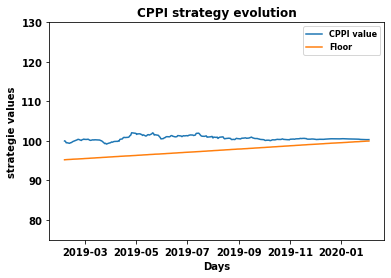

In [3]:
import matplotlib.pyplot as plt

def data(*ticker):
    my_data=pd.DataFrame()
    for t in ticker:
        my_data[t]= wb.DataReader(t,data_source='yahoo',start='2019-02-03', end='2020-02-03')['Adj Close']
    return my_data


my_data=data('DIS','CL=F','F','WINE.L')
# my_data=my_data[my_data.index>'2019-02-05']
my_data=my_data.pct_change()
my_data=my_data[1:]



C=CPPI(my_data,0.05,4,4,1,0.1,100)
V=C.value()
F=C.floor()
plt.ylim(75,130)
plt.plot(my_data.index,V)
plt.plot(my_data.index,F)
plt.xlabel('Days')
plt.ylabel('strategie values')
plt.title('CPPI strategy evolution')
plt.legend(['CPPI value','Floor'],fontsize=8)
plt.show()


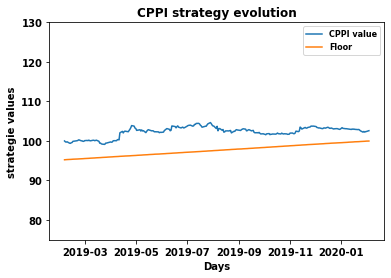

In [6]:
# CPPI Strategy using 1 risky asset using real data

from pandas_datareader import data as wb
import pandas as pd
#from cppi import CPPI
import matplotlib.pyplot as plt

def data(*ticker):
    my_data=pd.DataFrame()
    for t in ticker:
        my_data[t]= wb.DataReader(t,data_source='yahoo',start='2019-02-03', end='2020-02-03')['Adj Close']
    return my_data


my_data=data('DIS')
my_data=my_data.pct_change()
my_data=my_data[1:]


C=CPPI(my_data,0.05,4,1,1,0.1,100)
V=C.value()
F=C.floor()
plt.ylim(75,130)
plt.plot(my_data.index,V)
plt.plot(my_data.index,F)
plt.xlabel('Days')
plt.ylabel('strategie values')
plt.title('CPPI strategy evolution')
plt.legend(['CPPI value','Floor'],fontsize=8)
plt.show()

In [10]:
class Stoch_Ev:
    
    def __init__(self, S0, sigma, r, lamb, T, mu, delta, M):
        self.S0 = S0 # stock asset at time 0
        self.sigma = sigma # constant volatility of S
        self.T=T  #maturity 
        self.r = r
        self.lamb = lamb # related to jump ( poisson process)
        self.mu = mu
        self.M = M # discretization time steps
        self.delta = delta
    
    def value(self):
        dt= self.T/self.M
        rj = self.lamb * (np.exp(self.mu + 0.5 * self.delta ** 2) - 1)
        S = np.zeros((self.M + 1, 100))
        S[0] = self.S0
        sn1 = np.random.standard_normal((self.M + 1, 100)) # fixed number of simulation 100
        sn2 = np.random.standard_normal((self.M + 1, 100))
        poi = np.random.poisson(self.lamb * dt, (self.M + 1, 100))
        for t in range(1, self.M + 1, 1):
            #S[t] = S[t-1]*np.exp((self.r - 0.5*self.sigma**2)*dt + np.sqrt(dt)*self.sigma*np.random.standard_normal())
            S[t] = S[t - 1] * (np.exp((self.r - rj - 0.5 * self.sigma ** 2) * dt
                                      + self.sigma * np.sqrt(dt) * sn1[t])
                               + (np.exp(self.mu + self.delta * sn2[t]) - 1)
                               * poi[t])
            S[t] = np.maximum(S[t], 0)
        return S

In [11]:
class CPPI_Stoc:
    def __init__(self, data, rf, m, n, T, tol, K, sigma, mu):
        self.rf = rf ##free rate
        self.m = m ##multipler
        self.T = T  #maturity 
        self.tol = tol  #tolerence
        self.K = K   #strike
        self.n = n # number of assets
        self.data = data #
        self.sigma = sigma #returns standard deviation
        self.mu = mu    # drift
        self.data = data
        
    def floor(self):
        floor=[]
        h=T/len(self.data)
        for i in range(len(self.data)):
            floor+=[self.K / (1+self.rf)**(self.T - i*h)]
        return floor
        
    def value(self):
        V=[self.K]
        h=T/len(self.data)
        multiplier=[self.m]
        cushion=[V[0] - self.floor()[0]]
        
        expo_after_reb=[self.m * cushion[0]]
        expo_before_reb=[self.m * cushion[0]]
        for i in range(1, len(self.data)) :
            expo_before_reb += [(expo_after_reb[i - 1]/self.n ) * (self.n + self.data.iloc[i].sum())]
            V+=[expo_before_reb[i] + (V[i - 1] - expo_after_reb[i - 1]) * self.floor()[i] / self.floor()[i - 1]]
            cushion+=[cushion[i-1] * np.exp( ( self.rf-(self.mu-self.rf)*multiplier[i-1]-((self.sigma*multiplier[i-1])**2)/2)*h+self.sigma*self.n*np.sqrt(h)*np.random.standard_normal())]
            multiplier+=[expo_before_reb[i] / cushion[i]]
            if V[i] < self.floor()[i]:
                expo_after_reb.append(0)
            elif (multiplier[i] <= self.m * (1 + self.tol)) & (multiplier[i] >= self.m * (1 - self.tol)):
                expo_after_reb += [multiplier[i] * cushion[i]]
            else:
                expo_after_reb += [self.m * cushion[i]]
        return V

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
S0 = 100.                                                                      # Stock price at starting date
r = 0.05                                                                       # Risk-free rate
sigma = 0.25                                                                   # Volatility
lamb = 0.75                                                                   #jump intensity
mu = -0.6                                                                     #expected jump size
delta = 0.25                                                                 #Standard deviation of jump size
T = 1.0                                                                        # Maturity
M = 365
Stock = Stoch_Ev(S0, sigma, r, lamb, T, mu, delta, M)



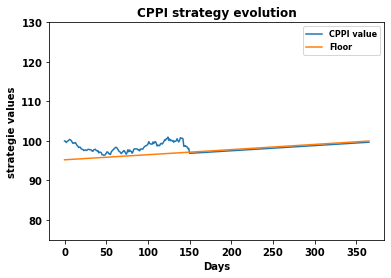

In [13]:
Stock_val = Stock.value()[:,4]
data_stock = pd.DataFrame(Stock_val)
data_stock=data_stock.pct_change()
C=CPPI_Stoc(data_stock,0.05,4,1,1,0,100,sigma,mu)
#C=CPPI(data_stock,0.05,4,1,1,0,100)
V=C.value()
F=C.floor()
plt.ylim(75,130)
plt.plot(data_stock.index,V)
plt.plot(data_stock.index,F)
plt.xlabel('Days')
plt.ylabel('strategie values')
plt.title('CPPI strategy evolution')
plt.legend(['CPPI value','Floor'],fontsize=8)
plt.show()

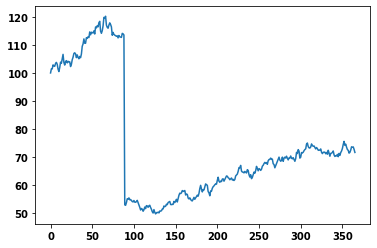

In [15]:
plt.plot(Stock.value()[:,4])

In [25]:
# MonteCarlo estimator

I = 1000

value = np.array.zeros(I,1)
for i in range(i,I):
    Stock = Stoch_Ev(S0, sigma, r, lamb, T, mu, delta, M)
    Stock_val = Stock.value()
    data_stock = pd.DataFrame(Stock_val)

    C = CPPI_Stoc(data_stock,0.05,4,1,1,0.1,100,sigma,mu)
    V = C.value()
    value[i-1] = V


print(V_T)
    


AttributeError: 'builtin_function_or_method' object has no attribute 'zeros'